In [1]:
from __future__ import annotations
import numpy as np
from operator import itemgetter
import numba as nb
import warnings
from dataclasses import dataclass
from typing import Callable
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.core.display import HTML, clear_output
import random
import itertools
import time
from abc import ABC, abstractmethod

In [2]:
#There is a lot of copying arrays and some memory inefficiencies. Most functions should work without modifying the input array. Further optimizations could be made with the compromise of
#less modularity 


from numba.core.types import functions
from numba.np.unsafe.ndarray import TypingError
    

class FitnessFunction:
    __slots__ = ("f","use_numba","_numbaized","fitness_func")

    def __init__(self, f: Callable, use_numba= True):
        self._numbaized = False
        if use_numba:
            try: 
                self.f = nb.njit(f)
                self._numbaized = True          
            except:
                self.f = f
                warnings.warn("Function can't be converted with numba! using pure Python")
        else:
            self.f = f

        if self._numbaized:
            self.fitness_func = self.fitness_f_nb
        else:
            self.fitness_func = self.fitness_f

    def __call__(self, population:np.array):
        fitness = self.fitness_func(self.f, population)
        return fitness

    @staticmethod
    @nb.njit
    def fitness_f_nb(f, population:np.array) -> np.array:
        N,M = population.shape
        fitness = np.zeros(N, dtype = float)

        for i in range(N):
            fitness[i] = f(population[i])
        return fitness

    @staticmethod
    def fitness_f(f, population:np.array) ->np.array:
        return np.apply_along_axis(f, 1, population)


class PopulationSelector:

    def __init__(self, funcs:list[Callable|str], probas:list=None):
        if probas is None:
            probas = np.ones(len(funcs))
        else:
            probas = np.array(probas)
        t = []
        for f in funcs:
            if type(f)==str:
                t.append(getattr(PopulationSelector, f))
            else:
                t.append(f)
        self.funcs = t
        self.probas = probas/probas.sum()

    def __call__(self, fitness:np.array, N):
        f = np.random.choice(self.funcs, p=self.probas)
        self.selected = f.__name__
        return f(fitness, N)

    @staticmethod
 
    def roulette_selection(fitness:np.array, N:int) ->np.array: #returns N pairs
        if fitness.sum() == 0:
          probas = np.full(len(fitness), 1/len(fitness))
        else:
          probas = fitness/fitness.sum()
        idx = np.arange(fitness.shape[0])
        p = np.random.choice(idx,
                             size = (N,2),
                             p=probas)
        return p

    @staticmethod
    def stochastic_universal_sampling(fitness:np.array, N:int) -> np.array: #This implementation might be wrong, but it's close enough ? gets N pairs
        N=2*N

        probas = fitness/fitness.sum()
        total = probas.sum()
        proportions = (probas*N/total).round().astype(int)
        proportions[-1] = N - (proportions[:-1]).sum()
        idx = np.arange(fitness.shape[0])
        pop = np.repeat(idx, proportions)
        np.random.shuffle(pop)

        return pop.reshape(N//2,2)

    @staticmethod
    def rank_based(fitness:np.array, N:int) -> np.array:
        ranks = np.argsort(fitness )
        probas = ranks/ranks.sum()
        idx = np.arange(fitness.shape[0])
        p = np.random.choice(idx,
                             size = (N,2),
                             p=probas)
        return p

    @staticmethod
    def scaled_selection(fitness:np.array, N:int, range: Tuple[int, int] = (50, 100)):
        A = np.array([[min(fitness), 1], [max(fitness), 1]])
        x = np.linalg.solve(A, np.array(range))
        scaled_fitness = x[0] * fitness + x[1]
        probas = scaled_fitness/scaled_fitness.sum()
        idx = np.arange(fitness.shape[0])
        p = np.random.choice(idx,
                             size = (N,2),
                             p=probas)
        return p


    @staticmethod
    def tournament_selection(fitness:np.array, N:int, tournament_size: int = 4): #Doesn't work with numba
        selected = np.zeros((N,2), dtype=int)
        for i in range(N):
            tournament = np.random.choice(fitness.shape[0], tournament_size, replace=False)
            selected[i] = tournament[np.argmax(fitness[tournament])]
        return selected

        

class Environment(tuple):
    def __new__(cls, population:np.array, err_funcs:FitnessFunction,optimizer:PopulationOptimizer,  problem: Callable = None):
        obj = tuple.__new__(cls, (population))
        obj.optimizer = optimizer
        obj.fitness = err_funcs
        obj.arr = population
        if(problem):
          obj.problem = problem
        return obj
    

    def run(self, iters=50, batches=10, top_k=0, verbose: bool = False):
        if(self.problem):
          return self.optimizer.optimize_draw(self.arr, self.fitness, selector, crossover, mutater, self.problem, iters, batches, top_k=top_k, verbose=verbose)
        return self.optimizer.optimize_draw(self.arr, self.fitness, selector, crossover, mutater, iters, batches, top_k=top_k, verbose=verbose)

    def selected(self):
        return [self.optimizer.crossover.selected, self.optimizer.mutater.selected]

        


class PopulationCrossover:
    def __init__(self, funcs:list[Callable|str], probas:list=None):
        if probas is None:
            probas = np.ones(len(funcs))
        else:
            probas = np.array(probas)
        t = []
        for f in funcs:
            if type(f)==str:
                t.append(getattr(PopulationCrossover, f))
            else:
                t.append(f)
        self.funcs = t
        self.probas = probas/probas.sum()
        self.params = (funcs, probas)

    def __call__(self, population_2d:np.array):
        f = np.random.choice(self.funcs, p=self.probas)
        self.selected = f.__name__
        return f(population_2d)


            
    
    @staticmethod
    @nb.njit
    def single_point_crossover(population_2d:np.array): #population_2d is an array with pairs of individuals. 
                                                        #Don't really know how to vectorize this. numpy won't allow me to have irregular shaped arrays :(
                                                        #Can probably use a weird shape like a triangle matrix or something or a [0,0,0,1..] mat
                                                        #Can probably create a mask first for the selection
        """population_2d -> numpy array with dims Nx2xlen_chromosome.
                            It contains pairs of individuals to make the crossover"""
        N = population_2d.shape[0]
        pop_N = population_2d.shape[2]
        cutoffs = np.random.randint(0, pop_N, size=N)
        new = np.zeros(population_2d.shape, dtype=population_2d.dtype)
        for i in range(N):
            
            new[i] = np.stack((np.concatenate((population_2d[i,0,:cutoffs[i]], population_2d[i,1,cutoffs[i]:]), axis=0), 
                                  np.concatenate((population_2d[i,1,:cutoffs[i]], population_2d[i,0,cutoffs[i]:]), axis=0)), axis=0)
            
            
        return new

    @staticmethod
    @nb.njit
    def k_point_crossover(population_2d:np.array, k:int=2)->np.array: #Fix this
        N = population_2d.shape[0]
        pop_N = population_2d.shape[2]
        cutoffs = np.random.randint(0, pop_N, size=(N,k)) #should have 2 points so dim (N,2,k)
        new = np.zeros(population_2d.shape, dtype=population_2d.dtype)
        for k in range(k):
            for i in range(N):
                
                new[i] = np.stack((np.concatenate((population_2d[i,0,:cutoffs[i,k]], population_2d[i,1,cutoffs[i,k]:]), axis=0), 
                                        np.concatenate((population_2d[i,1,:cutoffs[i,k]], population_2d[i,0,cutoffs[i,k]:]), axis=0)), axis=0)
                
                
            return new

    @staticmethod
    @nb.njit
    def uniform_crossover(population_2d:np.array)->np.array: #This could be more efficient, probably, or maybe not
        N = population_2d.shape[0]
        pop_N = population_2d.shape[2]

        idx = np.random.randint(0,2,size=population_2d.shape)
        new = np.zeros(population_2d.shape, dtype=population_2d.dtype)
        new[:,0,:] = np.where(idx[:,0,:], population_2d[:,0,:], population_2d[:,1,:])
        new[:,1,:] = np.where(idx[:,1,:], population_2d[:,0,:], population_2d[:,1,:])
        return new
        
    @staticmethod
    def ordered_crossover(population_2d:np.array)->np.array:
        N,num_genes, _ = population_2d.shape
        new_population = np.zeros_like(population_2d)
        for i in range(0, N, 2):
            parent_1 = population_2d[i]
            parent_2 = population_2d[i+1]
            cut_point_1, cut_point_2 = np.sort(np.random.choice(num_genes, 2, replace=False))
            child_1 = np.concatenate([parent_1[cut_point_1:cut_point_2], parent_2[cut_point_2:] + parent_2[:cut_point_2]])
            child_2 = np.concatenate([parent_2[cut_point_1:cut_point_2], parent_1[cut_point_2:] + parent_1[:cut_point_2]])
            new_population[i] = child_1
            new_population[i+1] = child_2
        return new_population

class PopulationMutater:

    def __init__(self, funcs: list[str|Callable], probas = None):
        t = []
        for f in funcs:
            if type(f)==str:
                t.append(getattr(PopulationMutater, f))
            else:
                t.append(f)
        self.funcs = t
        self.probas = probas

    def __call__(self, population):
        N = population.shape[0]
        pop_N = population.shape[1]
        self.selected=""
        for i,f in enumerate(self.funcs):
            temp = f(population)
            if self.probas:
                mask = np.tile(np.random.uniform(0,1, N )<self.probas[i], (pop_N,1)).T
                temp = np.where(mask, temp, population)
            population = temp
            self.selected+= " "+f.__name__
        return population


    @staticmethod
    @nb.njit
    def flip_all_bit(population:np.array)->np.array:
        return np.invert(population) #bitwise not


    @staticmethod
    def flip_bit(population:np.array)->np.array:
        N = population.shape[0]
        pop_N = population.shape[1]
        new = population.copy()
        r = np.random.randint(0, pop_N, size=N)
        
        first = np.arange(N)
        new[first,r] = np.invert(new[first,r])
        return new


    @staticmethod
    def swap_mutation(population:np.array)->np.array:
        N = population.shape[0]
        pop_N = population.shape[1]
        swaps = np.random.randint(0, pop_N, size=(N,2))
        
        new = population.copy()
        first = np.arange(N)
        
        new[first,swaps[:,1]] = new[first,swaps[:,0]] # for some reason new[:,swaps[:,0]] doesn't work as expected, also can't do this with numba on .-.

        new[first,swaps[:,0]] = population[first,swaps[:,1]]
                                
        return new

    @staticmethod
    @nb.njit
    def inversion_mutation(population:np.array)->np.array: # Numpy wont let me create irregular arrays again :(. Could try to do something smart like using a mask to select between the original
                                                            # and an inverted version of the population, but at that point I don't know how much, if any, more efficient it would be. Probably nothing
        N = population.shape[0]
        pop_N = population.shape[1]
        inversions = np.random.randint(0, pop_N, size=(N,2))
        first = np.arange(N)
        new = population.copy()
        for i in range(N):
            s1 = inversions[i,0]
            s2 = inversions[i,1]
            
            if s1>s2:
                s1, s2 = s2, s1
      
            new[i, s1:s2 ] = np.flip(population[i, s1:s2])

        return new


    @staticmethod
    @nb.njit
    def scramble_mutation(population:np.array)->np.array:
        N = population.shape[0]
        pop_N = population.shape[1]
        inversions = np.random.randint(0, pop_N, size=(N,2))
        first = np.arange(N)
        new = population.copy()
        for i in range(N):
            s1 = inversions[i,0]
            s2 = inversions[i,1]
            if s1>s2:
                s1, s2 = s2, s1
            
            new[i, s1:s2 ] = np.random.permutation(population[i, s1:s2])

        return new

    @staticmethod
    def blend_crossover(population:np.array)->np.array:
        population_size, num_genes = population.shape
        offspring_1 = np.zeros(num_genes)
        offspring_2 = np.zeros(num_genes)
        parent_1, parent_2 = np.random.choice(population, 2, replace=False)
        # mixing factor
        alpha = 0.5
        for i in range(num_genes):
            lower_bound = min(parent_1[i], parent_2[i])
            upper_bound = max(parent_1[i], parent_2[i])
            interval_length = upper_bound - lower_bound
            offspring_1[i] = np.random.uniform(lower_bound - alpha * interval_length,
                                              upper_bound + alpha * interval_length)
            offspring_2[i] = np.random.uniform(lower_bound - alpha * interval_length,
                                              upper_bound + alpha * interval_length)
        return np.array([offspring_1, offspring_2])

class PopulationOptimizer:
    def __init__(self, population:np.array,
                        fitness_func: Callable|FitnessFunction, 
                        selector: Callable|str|PopulationSelector,
                        crossover: Callable|str|PopulationCrossover,
                        mutater: Callable|str|PopulationMutater):
        N = population.shape[0]
        if N%2!=0:
            raise ValueError("Currently only works with an even number of individuals due to optimizations")
        self.population = population
        if type(crossover) == str:
            crossover = getattr(PopulationCrossover, crossover)

        if type(mutater) == str:
            mutater = getattr(PopulationMutater, mutater)
        if type(selector) == str:
            selector = getattr(PopulationSelector, selector)
        self.fitness_func = fitness_func
        self.crossover = crossover
        self.mutater = mutater
        self.metrics = {}


    @staticmethod
    @nb.jit(nopython=False, forceobj=True)
    def optimize_nb(population, fitness_func, selector, crossover, mutater, problem=None, top_k=5, iters=10): # A bigger population size is preferred, can probably optimize the for
        #fitness = np.zeros(population.shape[0])
        population = np.abs(population)
        for i in range(iters):
            dtype = population.dtype
            N = population.shape[0]
            pop_N = population.shape[1]
            if(problem):
                fitness = problem.simulate(population)
            else:
                fitness = fitness_func(population)
            #print(population)
            best_n = population[np.flipud((np.argsort(fitness)))[:top_k]]
            selected = population[selector(fitness, N//2)]
            cross = crossover(selected).reshape(N, pop_N)
            mutated = mutater(cross)
            population = mutated
            r = np.random.randint(0, N, size=top_k)
            population[r] = best_n
            
            
            """#coincidencia de accion con definida en conditions
            for j in conditionals.conditions:
              if population[k][l] == j:
                #si es-1 es pos del agente, aqui es recoger
                if j[1][0] == -1 and j[1][0] == -1:
                  if conditionals.space[pos_agente[0], pos_agente[1]] == j[1][2]:
                    #acumular reward o penalties
                    if j[2][1] == 1: #pick
                      conditionals.space[pos_agente[0], pos_agente[1]] = 0
                    res_fitness[j[2][0]]+= j[2][1]
                #usar pos agente y
                elif j[1][0] != -1:
                  if conditionals.space[j[1][0], pos_agente[1]] == j[1][2]:
                    #acumular reward o penalties
                    res_fitness[j[2][0]]+= j[2][1]"""








            #print(f"conditionals ${conditionals.conditions} pop {population[0:3]}")
        return population, fitness

    @staticmethod
    def optimize_metrics(population, fitness_func, selector, crossover, mutater, problem = None, iters=10, batches=10, get_best_n=5, top_k=5, verbose: bool = False):
        metrics = {}
        metrics["best_n"] = []
        metrics["worst_n"] = []
        metrics["mean"] = []
        metrics["best_chromosome"] = []
        metrics["last_population"] = None
        metrics["last_fitness"] = None
        metrics["fits"] = None
        for batch in tqdm(range(batches)):
            population, current_fit = PopulationOptimizer.optimize_nb(population,  fitness_func, selector, crossover, mutater, problem,  iters=iters, top_k=top_k)
            #current_fit = fitness_func(population)
            if verbose:
                if batch%verbose==0:
                     print(f"Batch {batch + 1}: Fitness = {current_fit.min():.4f}")
            b_n = np.flipud(np.argsort(current_fit))
            best_n = current_fit[b_n[:get_best_n]]
            worst_n = current_fit[np.flipud(b_n)[:get_best_n]]
            best_c = population[b_n[0]]
            metrics["mean"].append(current_fit.mean())
            metrics["best_n"].append(best_n)
            metrics["worst_n"].append(worst_n)
            metrics["best_chromosome"].append(best_c)
            metrics["last_population"] = population
            metrics["last_fitness"] = current_fit
        return metrics

    

    @staticmethod
    def optimize_draw(population, fitness_func, selectorr, crossover, mutater, problem, iters=10, batches=10,disable=False, get_best_n=5, top_k=5, verbose: bool = False):
        metrics = PopulationOptimizer.optimize_metrics(population, fitness_func, selectorr, crossover, mutater,problem, iters=iters,
                                                       batches=batches, get_best_n=get_best_n, top_k=top_k, verbose=verbose)
        fig, axs = plt.subplots(1, 4, figsize=(15, 4))
        fig.suptitle(f"Selector: {selectorr.selected}\n Crossover: {crossover.selected} \n Mutater: {mutater.selected}", fontsize=8, fontweight='bold')
        axs[0].plot(np.arange(len(metrics["mean"])), metrics["mean"])
        axs[0].set_title('mean')
        axs[1].plot(np.arange(len(metrics["best_n"])), [x[0] for x in metrics["best_n"]])
        axs[1].plot(np.arange(len(metrics["worst_n"])), [x[0] for x in metrics["worst_n"]])
        axs[1].set_title('best and worst')
        axs[2].boxplot(metrics["last_fitness"])
        axs[2].set_title('boxplot last fitness')
        axs[3].hist(metrics["last_fitness"])
        axs[3].set_title('hist last fitness')
        plt.tight_layout()
        plt.show()
        return metrics

class Utils:
   
  def dibuja(self,robot,  espacio, text):
    cadena =   """
    <style>
    table {
      border-collapse: collapse;
    }
    td {
      border: 1px solid black;
      width: 40px;
      height: 40px;
      text-align: center;
    }

    .oscuro{
      background-color:black;
      width:100%;
      height: 100%;

    }
    img{
      width:100%;
      height: 100%;
    }
    </style>
    <table>"""

    cadena+=f"<h1>{text}</h1>"
    for i in range(espacio.shape[0]):
      cadena+="<tr>"
      for j in range(espacio.shape[1]):
        cadena+="<td>"
        if i == robot[0] and j == robot[1]:
          cadena+="<img src ="'https://thumbs.dreamstime.com/b/robot-de-dibujos-animados-hablando-feliz-ilustraci%C3%B3n-dise%C3%B1o-caracteres-felices-191439909.jpg'">"
        elif espacio[i][j] == 1:
          cadena+="<img src ="'https://img.freepik.com/vector-premium/lata-aluminio-brillante-refresco-o-plantilla-cerveza-blanco_88653-860.jpg'">"
        cadena+="</td>"
      cadena+="</tr>"
    cadena+="</table>"
    return cadena 

In [3]:
class Problem(ABC):
  def __init__(self, space:np.array=None, conditions:np.array=None, comparator: np.array = None):
    self.space = space
    self.conditions = conditions
    self.comparator = comparator

    @abstractmethod
    def simulate(self, population):
        pass

In [4]:
class RobbyRobot(Problem):
  def __init__(self, space):
        super().__init__(space=space)

  def do_it(self, len_chromosome, pos_agente,strategy, res_fitness, esp_original, draw = False):
        if(draw):
          ut = Utils()
        for l in range(len_chromosome):
          to_evaluate = [[pos_agente[0]-1, pos_agente[1]], 
                          [pos_agente[0]+1, pos_agente[1]], 
                          [pos_agente[0], pos_agente[1]+1], 
                          [pos_agente[0], pos_agente[1]-1],
                          [pos_agente[0], pos_agente[1]]]
          perspective = []
          for i in to_evaluate:
            if i[0] <0 or i[0] == self.space.shape[0] or i[1] <0 or i[1] == self.space.shape[1]:
              perspective.append(2)
            else:
              perspective.append(self.space[i[0]][i[1]])
          perspective = tuple(perspective)
          action = strategy.get(perspective, -1)
          #evaluate action given the perspective
          if action == 6: #random
            action = random.randint(0,5)
          if action == 0:  #north
            if perspective[0] == 2:
              res_fitness[1]+= 5 
            else:
              pos_agente[0]-=1
          elif action == 1: #south
            if perspective[1] == 2:
              res_fitness[1]+= 5 
            else:
              pos_agente[0]+=1
          elif action == 2: #east
            if perspective[2] == 2:
              res_fitness[1]+= 5 
            else:
              pos_agente[1]+=1
          elif action == 3: #west
            if perspective[3] == 2:
              res_fitness[1]+= 5 
            else:
              pos_agente[1]-=1
          elif action == 5: #pick
            if self.space[pos_agente[0]][pos_agente[1]] == 1:
              res_fitness[0]+= 10 
              self.space[pos_agente[0]][pos_agente[1]] = 0
            else:
              res_fitness[1]+= 1 
          if(draw):
            display(HTML(ut.dibuja([pos_agente[0], pos_agente[1]], self.space, f'Action {action} Perspective {perspective}')))
            time.sleep(1)
            if(l < len_chromosome-1):
              clear_output(wait=True)
          if(l == len_chromosome-1):
            self.space = esp_original.copy()
        return res_fitness

  def simulate(self, population):
    fitness = np.zeros(population.shape[0])
    res_fitness = np.zeros(2, dtype = int)
    combinations = list(itertools.product([0, 1, 2], repeat=5))
    esp_original = self.space.copy()
    for k in range(population.shape[0]):
      pos_agente = [0,0]
      res_fitness[0] = 0
      res_fitness[1] = 1
      strategy = {c: population[k][ind] for ind, c in enumerate(combinations)}
      res_fitness = self.do_it(population.shape[1], pos_agente, strategy, res_fitness, esp_original)
      #fitness[k] = fitness_func(res_fitness[0], res_fitness[1])
      fitness[k] = res_fitness[0]/ res_fitness[1]
    return fitness

In [5]:
crossovers=["single_point_crossover", "k_point_crossover", "uniform_crossover", "ordered_crossover"]
mutation =  ["flip_all_bit", "flip_bit", "swap_mutation", "inversion_mutation", "scramble_mutation"]
selectors  = ["roulette_selection", "rank_based",  "scaled_selection", "tournament_selection"]

##Best selector for Robby the Robot

100%|██████████| 10/10 [01:02<00:00,  6.27s/it]


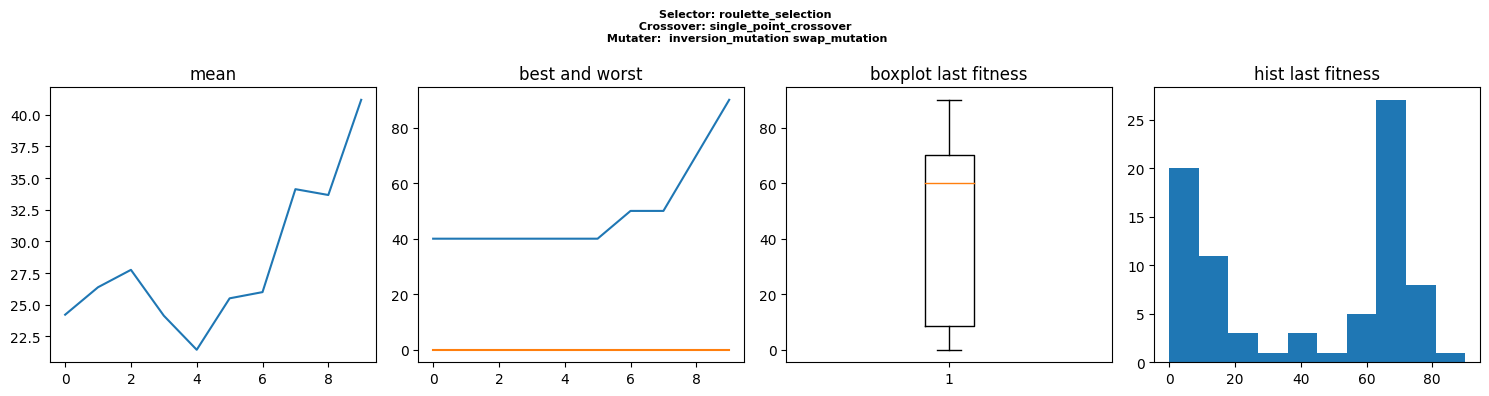

100%|██████████| 10/10 [00:43<00:00,  4.30s/it]


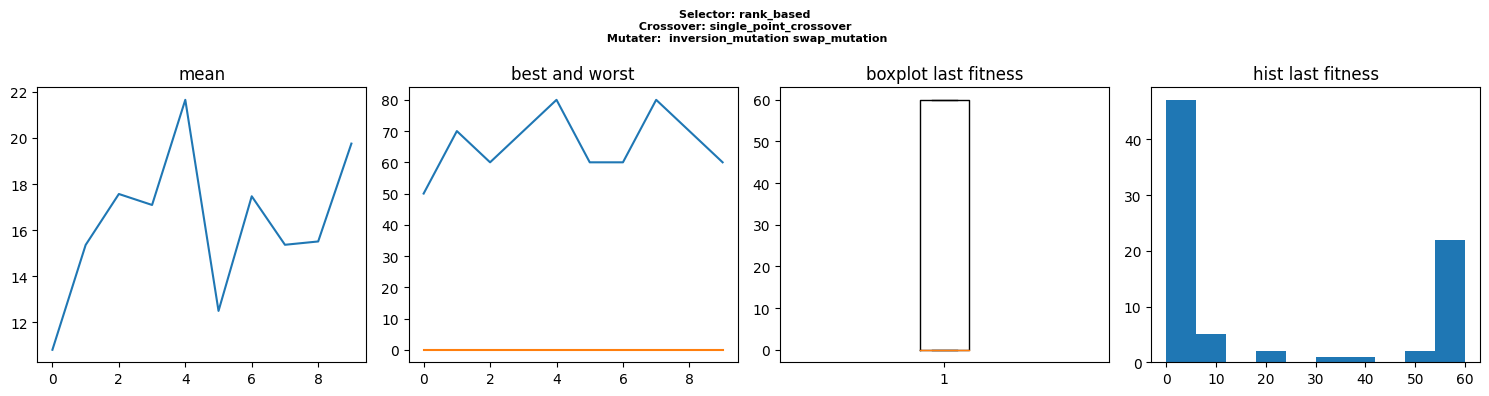

100%|██████████| 10/10 [00:48<00:00,  4.81s/it]


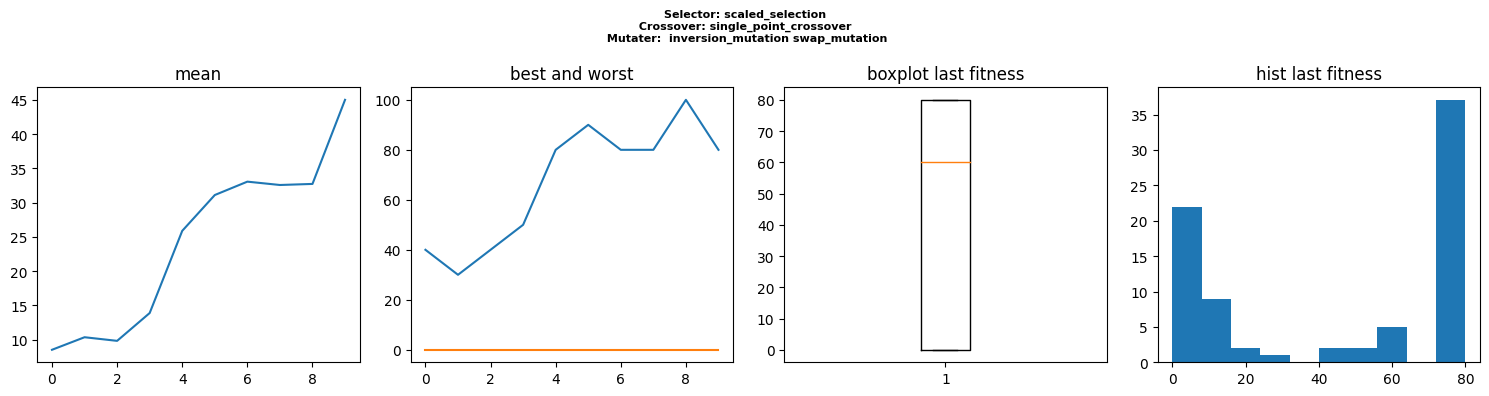

100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


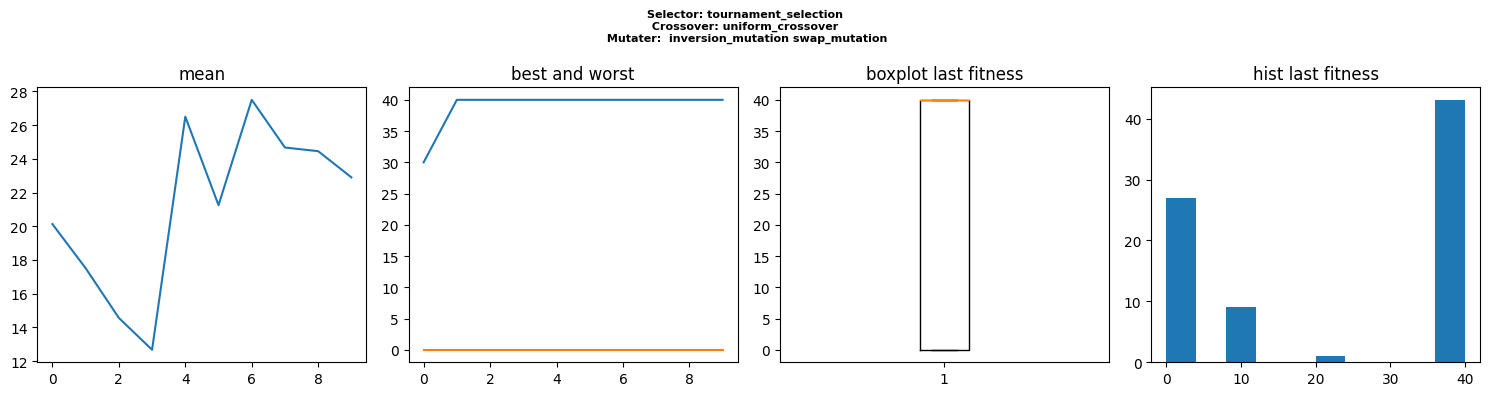

In [6]:
final_metrics= np.array([])
met= np.array([])
espacio = np.random.choice([0, 1], size=(10,10), p=[0.5, 0.5])
roby_problem = RobbyRobot(espacio)
for i in selectors:
  fitness = FitnessFunction(lambda rewards, penalties: rewards/penalties)
  selector = PopulationSelector([i])     
  crossover = PopulationCrossover(["uniform_crossover", "single_point_crossover"], probas=[0.5,0.5]) 
  mutater = PopulationMutater([ "inversion_mutation", "swap_mutation"], probas=[0.6, 0.3])
  darr = np.random.randint(0,2, size=(8,4))
  optimizer = PopulationOptimizer(darr, fitness, selector, crossover, mutater)
  arr = np.random.randint(0,7, size=(80,243))
  env = Environment(arr, fitness, optimizer, roby_problem)
  metrics = env.run(iters=30, batches=10, top_k=15)
  met = np.append(met, metrics)

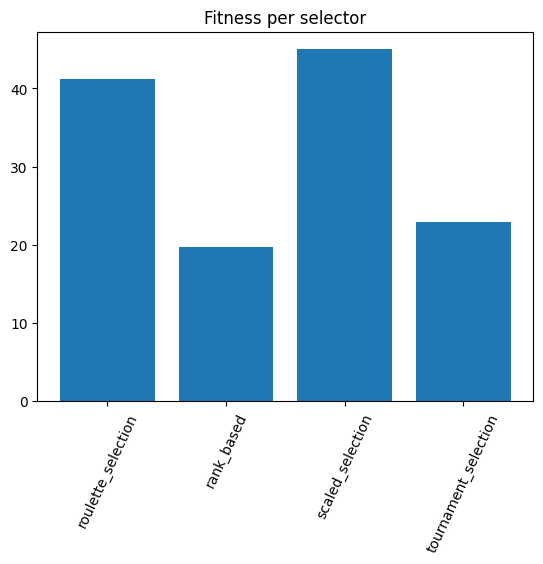

In [7]:
final_metrics = [i["mean"][-1] for i in met]
plt.title("Fitness per selector")
plt.bar(selectors, final_metrics)
plt.xticks(rotation=65)
plt.show()

##Best mutator for Robby the Robot

100%|██████████| 10/10 [00:26<00:00,  2.67s/it]


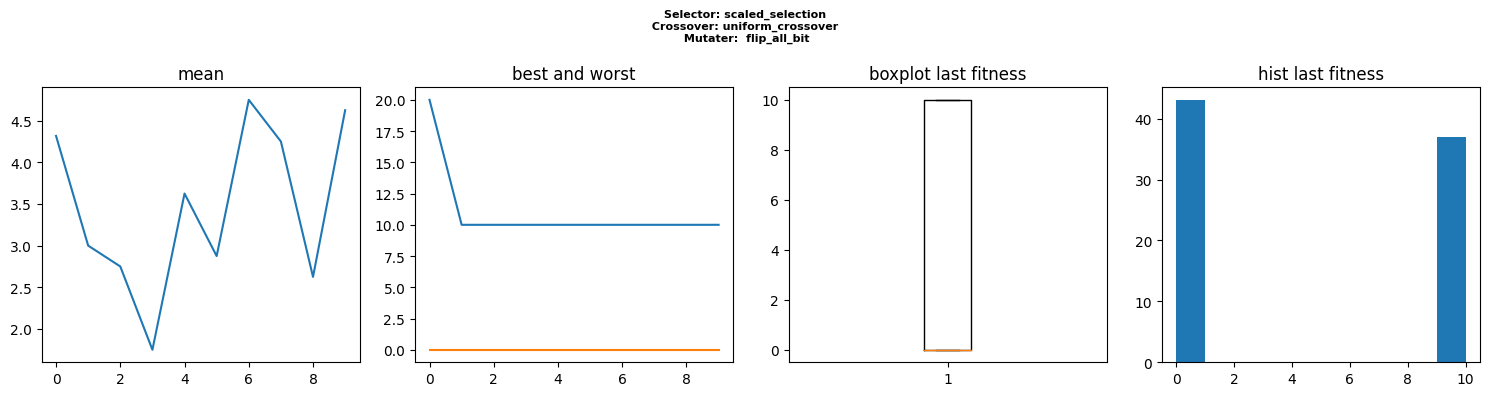

100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


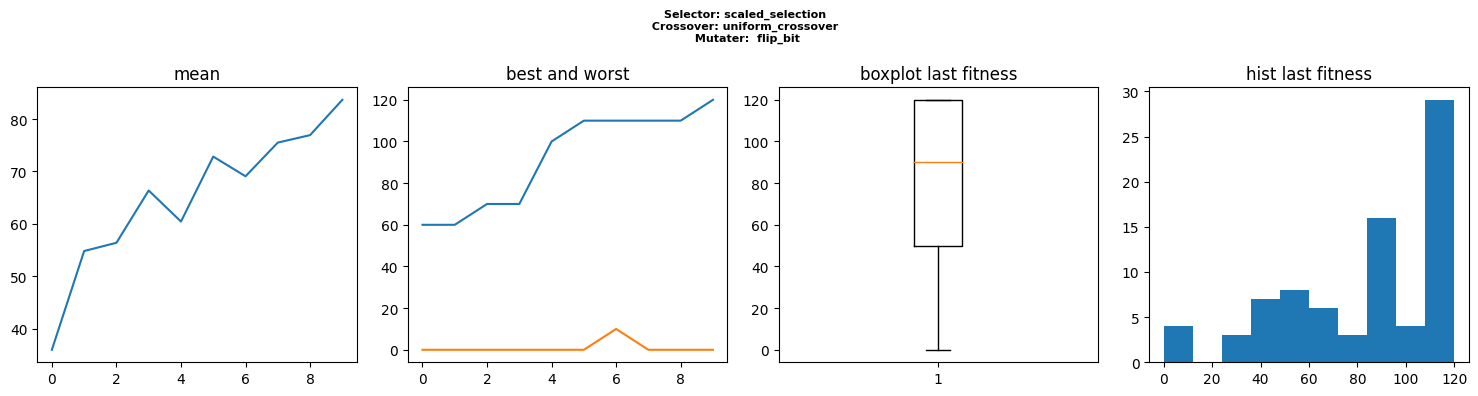

100%|██████████| 10/10 [00:29<00:00,  2.97s/it]


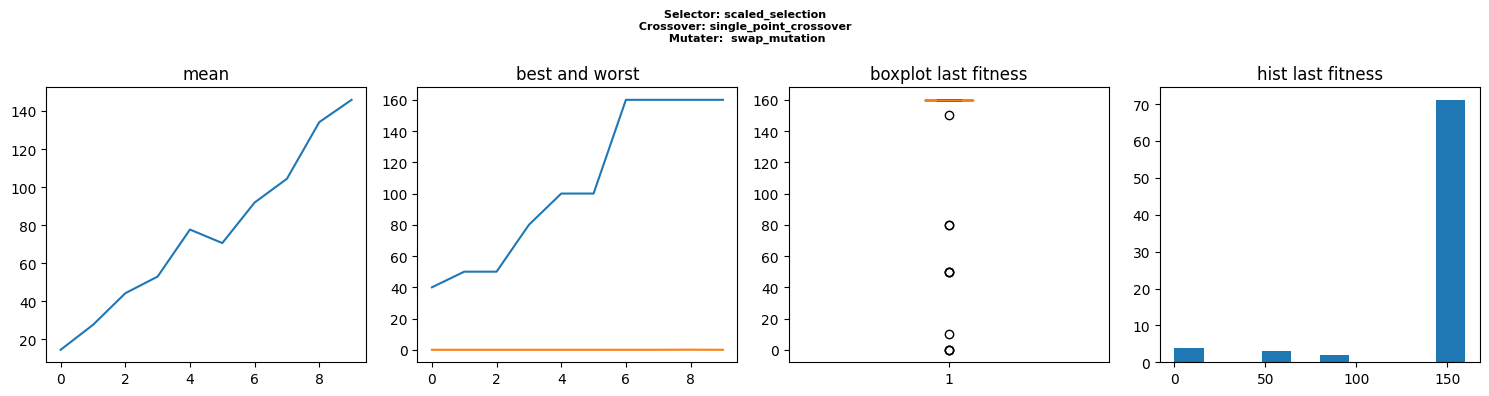

100%|██████████| 10/10 [00:28<00:00,  2.89s/it]


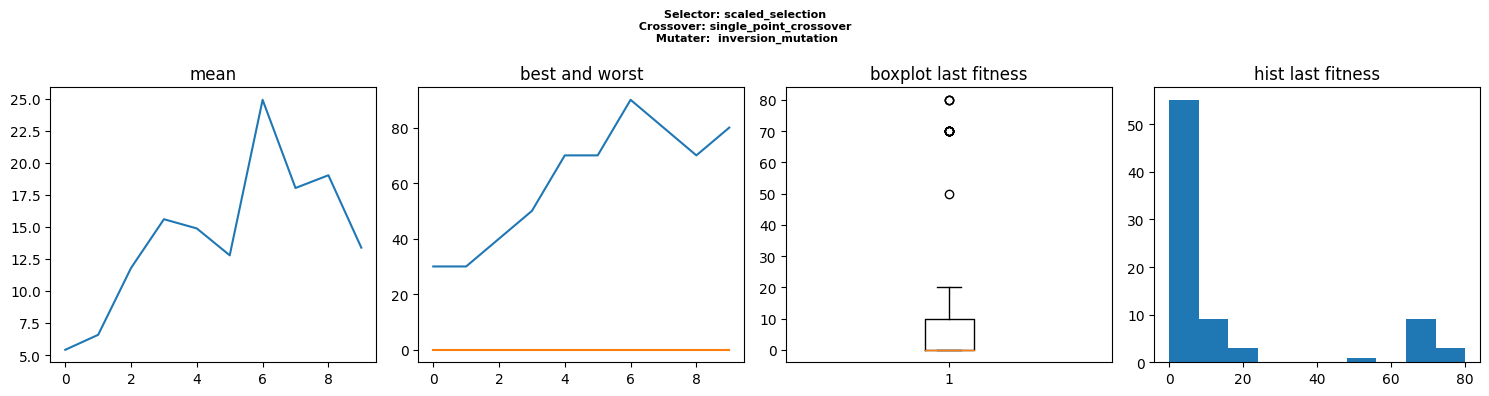

100%|██████████| 10/10 [00:31<00:00,  3.14s/it]


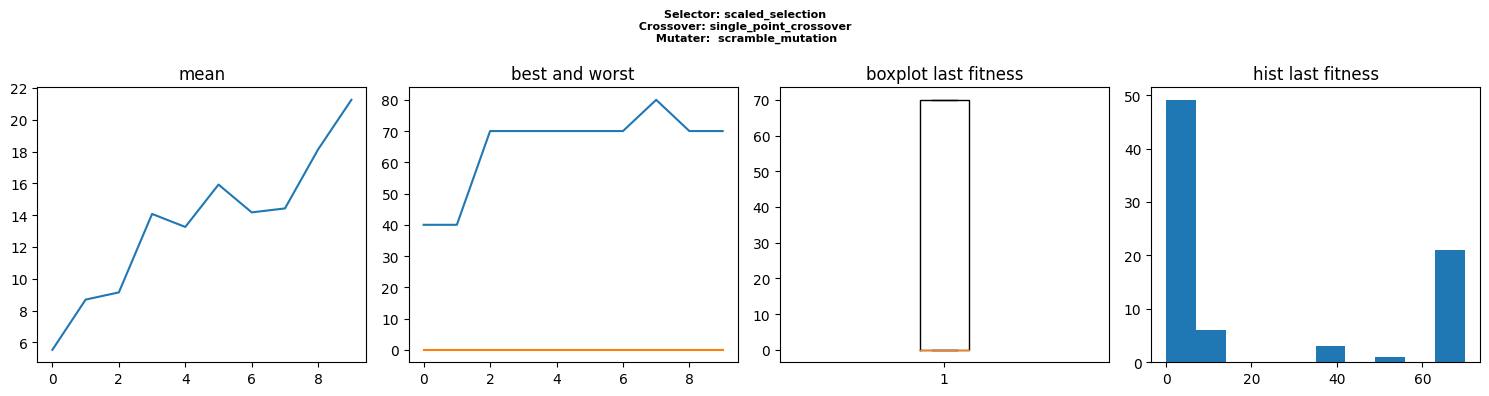

In [9]:
#Mutation
best_selector = selectors[np.argmax(final_metrics)]
final_metrics_m= np.array([])
met_m = np.array([])
for i in mutation:
  fitness = FitnessFunction(lambda rewards, penalties: rewards/penalties)
  selector = PopulationSelector([best_selector])     
  crossover = PopulationCrossover(["uniform_crossover", "single_point_crossover"], probas=[0.5,0.5]) 
  mutater = PopulationMutater([i])
  darr = np.random.randint(0,2, size=(8,4))
  optimizer = PopulationOptimizer(darr, fitness, selector, crossover, mutater)
  arr = np.random.randint(0,7, size=(80,243))
  env = Environment(arr, fitness, optimizer, roby_problem)
  metrics = env.run(iters=20, batches=10, top_k=15)
  met_m = np.append(met_m, metrics)

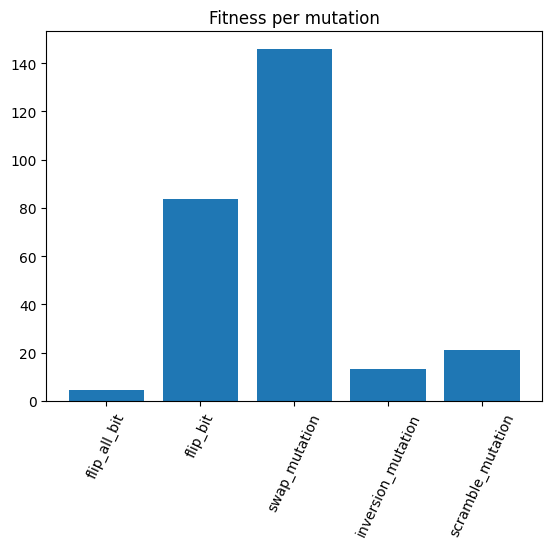

In [10]:
final_metrics_m = [i["mean"][-1] for i in met_m]
plt.title("Fitness per mutation")
plt.bar(mutation, final_metrics_m)
plt.xticks(rotation=65)
plt.show()

##Best crossover for Robby the Robot

100%|██████████| 10/10 [00:46<00:00,  4.62s/it]


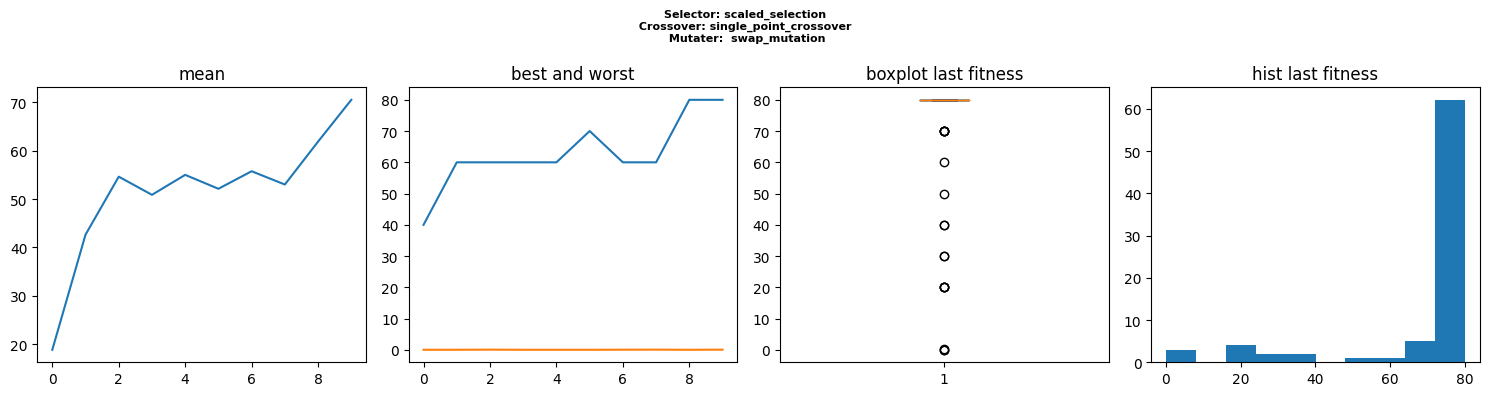

100%|██████████| 10/10 [00:46<00:00,  4.63s/it]


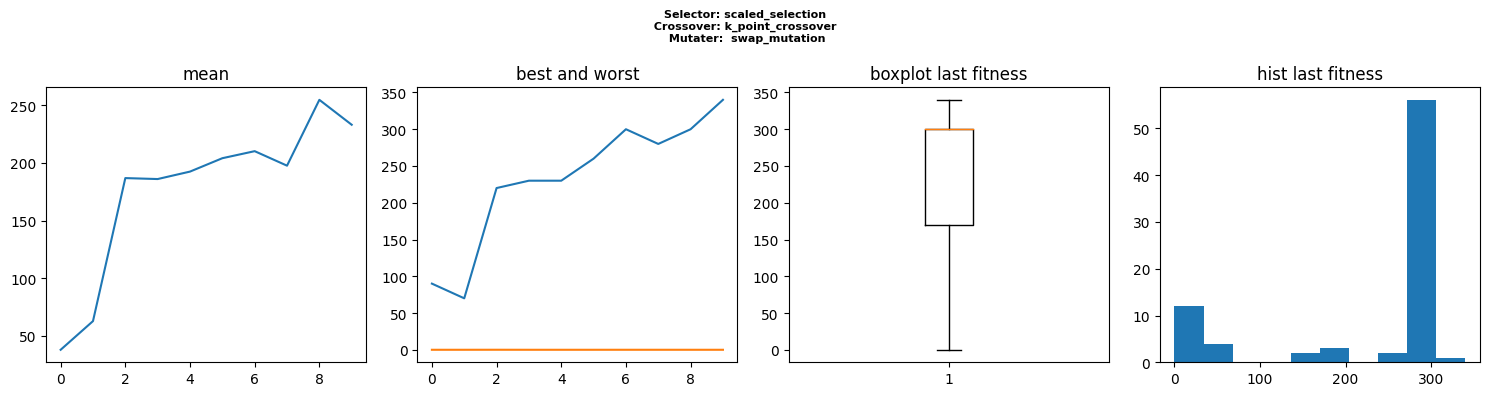

100%|██████████| 10/10 [00:45<00:00,  4.55s/it]


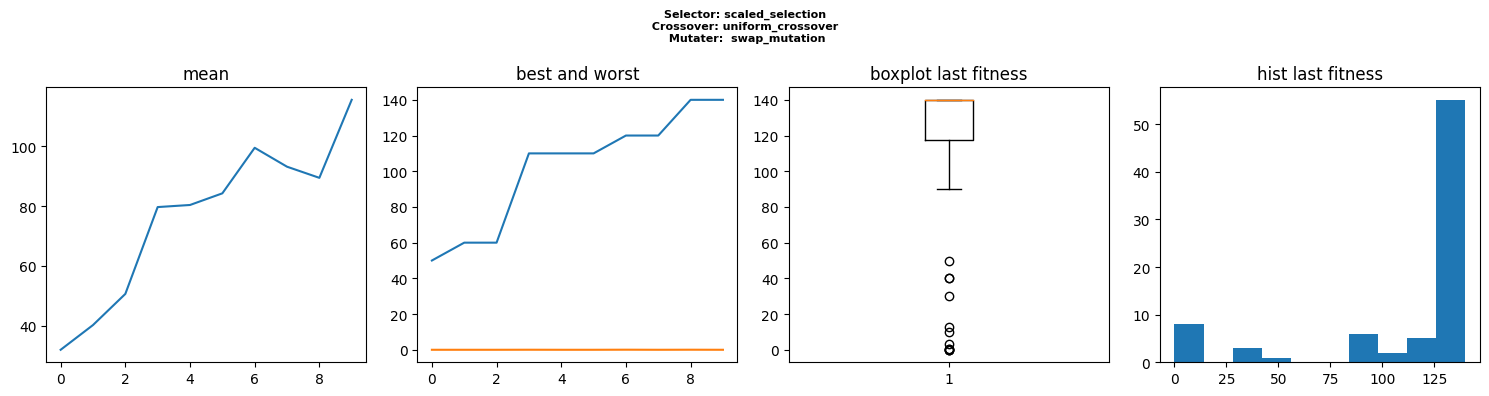

100%|██████████| 10/10 [00:44<00:00,  4.42s/it]


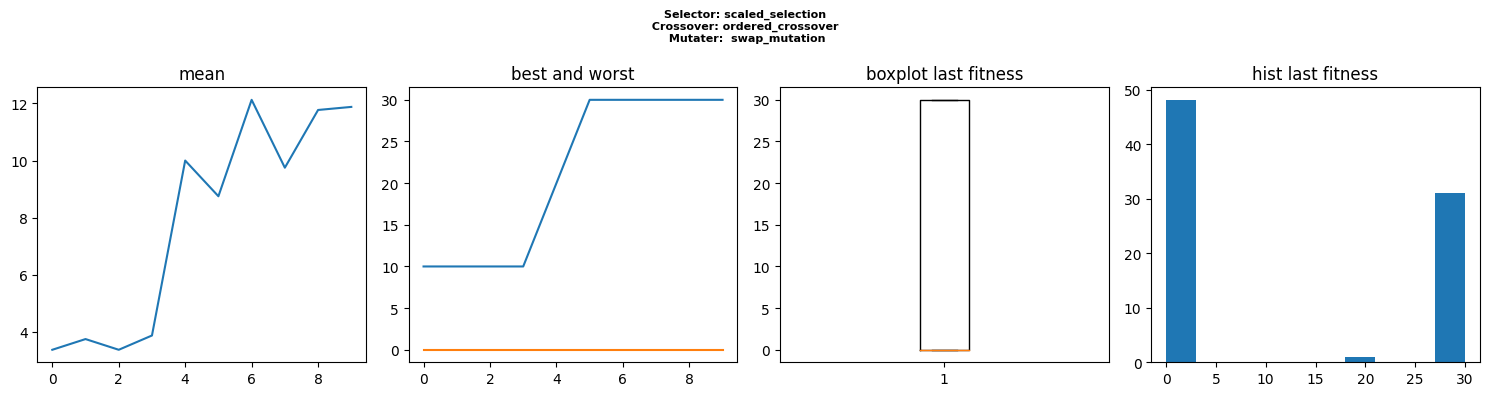

In [11]:
best_selector = selectors[np.argmax(final_metrics)]
best_mutator = mutation[np.argmax(final_metrics_m)]
met_c = np.array([])
for i in crossovers:
  fitness = FitnessFunction(lambda rewards, penalties: rewards/penalties)
  selector = PopulationSelector([best_selector])     
  crossover = PopulationCrossover([i]) 
  mutater = PopulationMutater([best_mutator])
  darr = np.random.randint(0,2, size=(8,4))
  optimizer = PopulationOptimizer(darr, fitness, selector, crossover, mutater)
  arr = np.random.randint(0,7, size=(80,243))
  env = Environment(arr, fitness, optimizer, roby_problem)
  metrics = env.run(iters=30, batches=10, top_k=15)
  met_c = np.append(met_c, metrics)

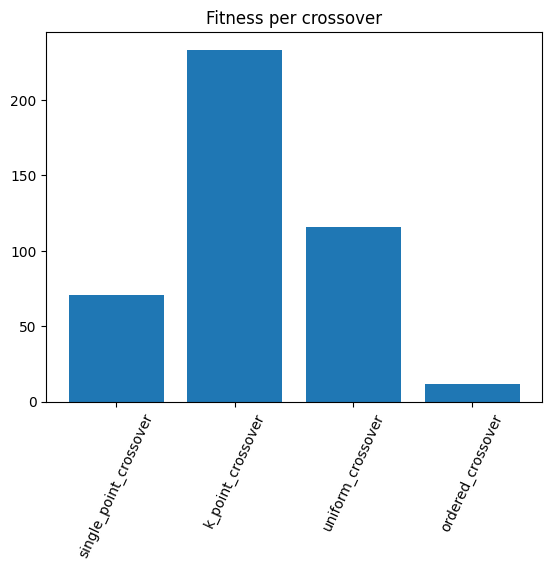

In [12]:
final_metrics_c = [i["mean"][-1] for i in met_c]
best_crossover = crossovers[np.argmax(final_metrics_c)]
plt.title("Fitness per crossover")
plt.bar(crossovers, final_metrics_c)
plt.xticks(rotation=65)
plt.show()

##Experiment with the best operators.

100%|██████████| 100/100 [07:34<00:00,  4.54s/it]


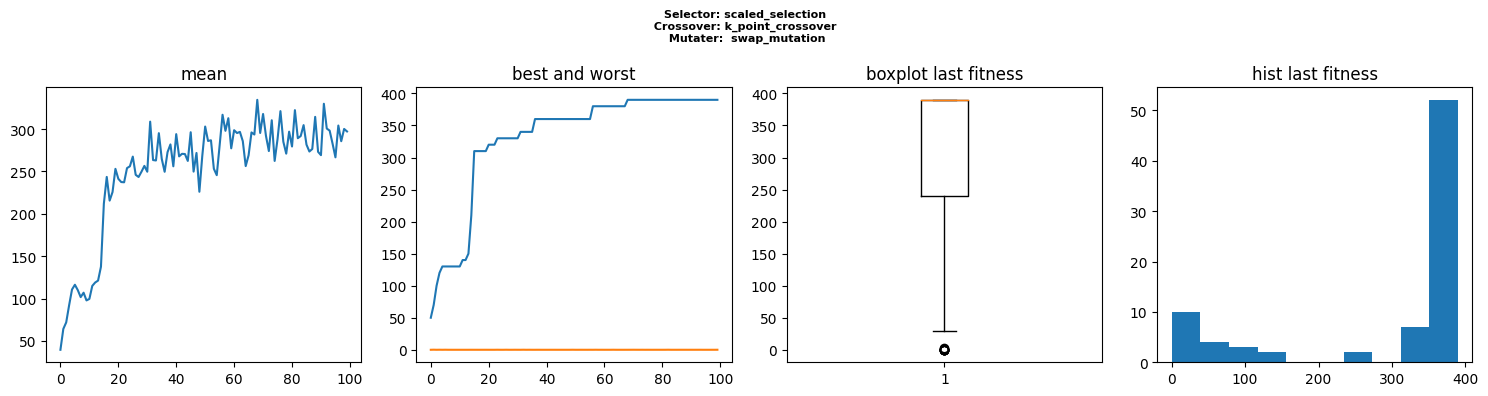

In [13]:
fitness = FitnessFunction(lambda rewards, penalties: rewards/penalties)
selector = PopulationSelector([best_selector])     
crossover = PopulationCrossover([best_crossover]) 
mutater = PopulationMutater([best_mutator])
darr = np.random.randint(0,7, size=(8,4))
optimizer = PopulationOptimizer(darr, fitness, selector, crossover, mutater)
espacio = np.random.choice([0, 1], size=(10,10), p=[0.5, 0.5])
roby_problem = RobbyRobot(espacio)
arr = np.random.randint(0,6, size=(80,243))
gens = 100
env = Environment(arr, fitness, optimizer, roby_problem)
metrics = env.run(iters=30, batches=gens, top_k=15)

In [14]:
best_fit =np.argmax(metrics['mean'])
metrics['mean'][best_fit]

334.511756921734

In [15]:
metrics['best_chromosome'][best_fit]

array([1, 5, 1, 1, 3, 3, 0, 1, 0, 2, 5, 5, 5, 3, 1, 4, 5, 3, 0, 5, 5, 1,
       1, 0, 0, 1, 5, 2, 0, 1, 1, 4, 1, 2, 2, 3, 1, 1, 1, 3, 5, 2, 1, 1,
       1, 1, 5, 4, 1, 0, 1, 5, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 3, 3, 1, 3,
       1, 1, 1, 1, 3, 1, 4, 5, 3, 1, 1, 1, 5, 3, 0, 0, 5, 1, 3, 3, 4, 5,
       0, 5, 0, 5, 3, 3, 0, 4, 3, 1, 1, 0, 5, 0, 0, 1, 1, 1, 1, 3, 4, 1,
       3, 0, 5, 3, 1, 5, 4, 0, 5, 5, 1, 1, 1, 0, 5, 3, 5, 1, 1, 3, 1, 5,
       1, 5, 5, 5, 0, 1, 5, 1, 1, 0, 5, 3, 1, 5, 1, 5, 4, 0, 1, 0, 5, 1,
       0, 0, 1, 1, 4, 1, 1, 3, 1, 5, 1, 1, 0, 1, 5, 0, 5, 1, 5, 5, 3, 5,
       5, 2, 5, 5, 3, 5, 1, 3, 5, 1, 1, 1, 5, 1, 5, 3, 1, 5, 1, 3, 1, 4,
       1, 5, 4, 5, 1, 1, 1, 4, 1, 1, 0, 1, 1, 5, 1, 0, 1, 1, 5, 5, 1, 1,
       1, 1, 5, 1, 1, 3, 3, 0, 1, 1, 5, 5, 5, 5, 3, 0, 1, 5, 1, 0, 5, 5,
       3])

In [16]:
combinations = list(itertools.product([0, 1, 2], repeat=5))
strategy = {c: metrics['best_chromosome'][best_fit][ind] for ind, c in enumerate(combinations)}

In [17]:
roby_problem.do_it(len(strategy), [0,0],strategy, [0,0], espacio, draw = True)

,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,
,,,,,,,,,


[380, 0]

2.

In [18]:
class PatternProblem(Problem):
  def __init__(self, comparator):
        super().__init__(comparator=comparator)
        
  def simulate(self, population):
    fitness = np.zeros(population.shape[0])
    for k in range(population.shape[0]):
      fitness[k] = (self.comparator == population[k]).sum()
    return fitness

In [30]:
def do_many(images, fitness, optimizer, initial_population = 80, gens = 300, iters=120, top_k=15):
    umbral = 127
    metrics = np.array([])
    bests = []
    for i in images:
      img = np.mean(plt.imread(i), axis=2)
      img = (img > umbral).astype(np.uint8)
      flat_img = np.reshape(img, img.shape[0]*img.shape[1])
      pp = PatternProblem(flat_img)
      arr = np.random.randint(0,2, size=(initial_population,flat_img.shape[0]), dtype=bool)
      env = Environment(arr, fitness, optimizer, pp)
      metric = env.run(iters=iters, batches=gens, top_k=top_k)
      metrics = np.append(metrics, metric)
      best = metric['best_chromosome'][np.argmax(metric['mean'])].reshape(img.shape[0], img.shape[1])
      bests.append(best)
    return metrics, bests

In [31]:
images = np.array(["/content/andres.jpeg","/content/santiago.jpeg", "/content/gabriela.jpeg", "/content/sag.jpeg"])
selector = PopulationSelector(["roulette_selection"])     
crossover = PopulationCrossover(["single_point_crossover"], probas=[1]) 
mutater = PopulationMutater([ "inversion_mutation", "swap_mutation"], probas=[ 0.6, 0.4])
darr = np.random.randint(0,7, size=(8,4))
optimizer = PopulationOptimizer(darr, fitness, selector, crossover, mutater)

In [32]:
img = np.mean(plt.imread(images[0]), axis=2)

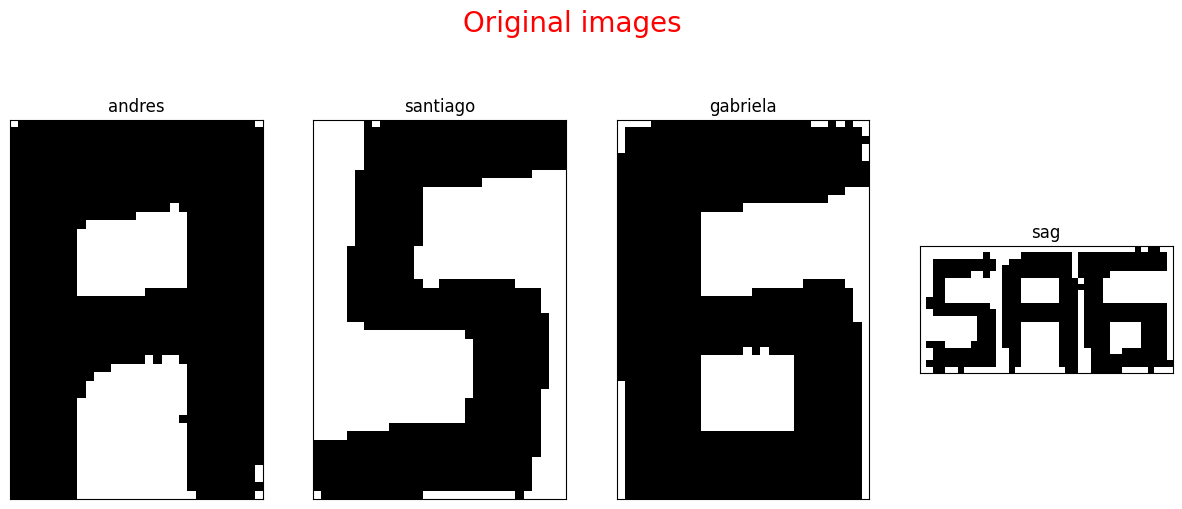

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=images.shape[0], figsize=(15, 8))
fig.suptitle('Original images', fontsize=20, color = 'red')
for i in range(images.shape[0]):
  img = np.mean(plt.imread(images[i]), axis=2)
  img = (img > 127).astype(np.uint8)
  axs[i].imshow(img, cmap='gray')
  axs[i].set_title(images[i].split("/")[2].split(".")[0])
  axs[i].set_xticks([])
  axs[i].set_yticks([])
fig.subplots_adjust(top=1.1)
plt.show()

100%|██████████| 300/300 [01:04<00:00,  4.67it/s]


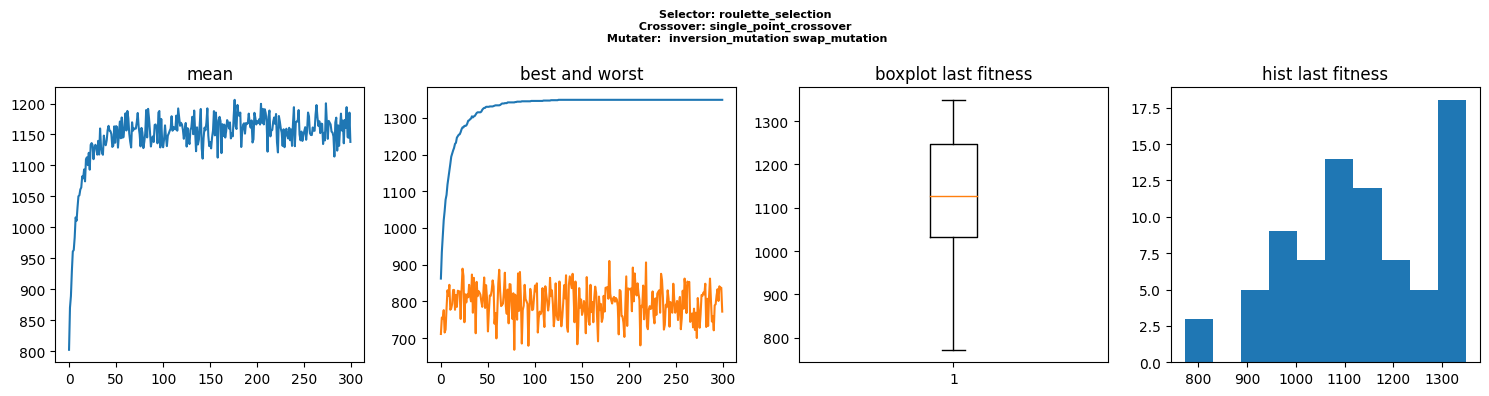

100%|██████████| 300/300 [01:06<00:00,  4.54it/s]


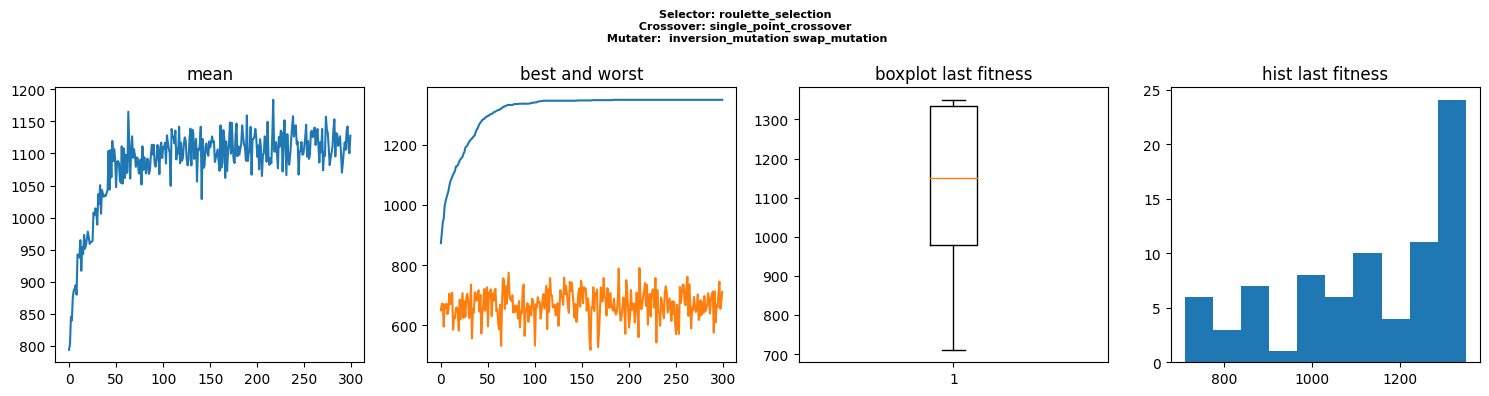

100%|██████████| 300/300 [01:07<00:00,  4.43it/s]


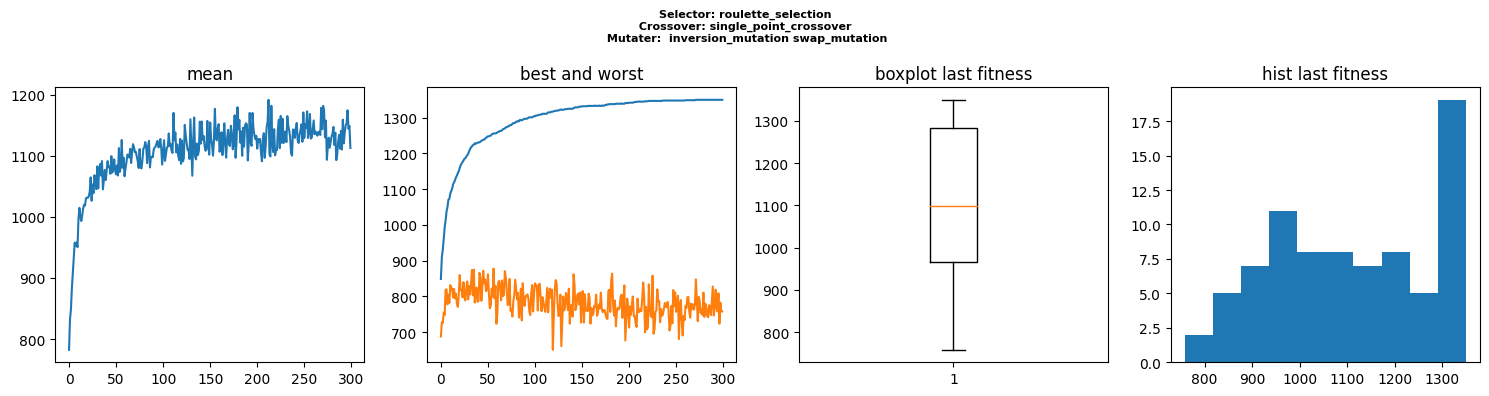

100%|██████████| 300/300 [00:50<00:00,  5.93it/s]


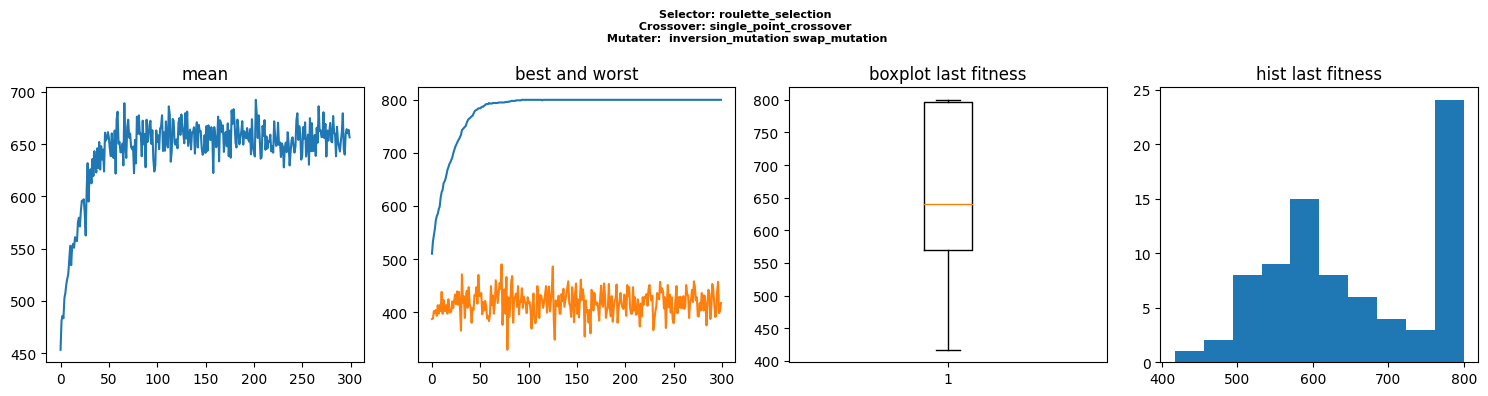

In [33]:
metrics, best = do_many(images, fitness, optimizer)

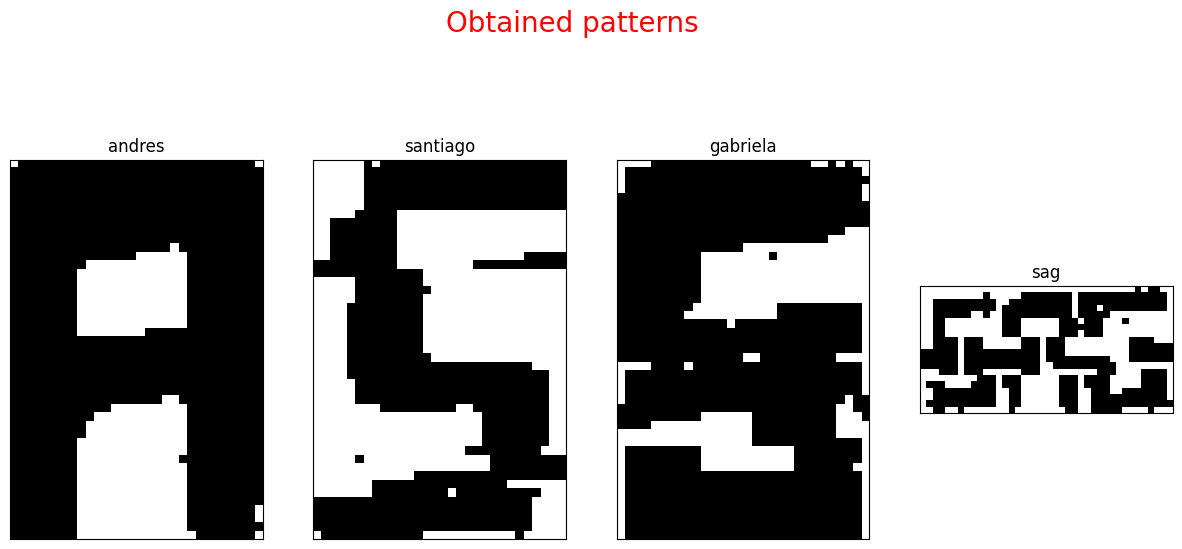

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=images.shape[0], figsize=(15, 8))
fig.suptitle('Obtained patterns', color = 'red', fontsize = 20)
for i in range(images.shape[0]):
  axs[i].imshow(best[i], cmap='gray')
  axs[i].set_title(images[i].split("/")[2].split(".")[0])
  axs[i].set_xticks([])
  axs[i].set_yticks([])
fig.subplots_adjust(top=1)
plt.show()

1. It is observed that the best strategy is obtained using the roulette selector, the swap mutation mutator, and k-point crossover. Similarly, with a relatively small number of generations, it is possible to obtain a good strategy for Robby the Robot. The simulation can be observed after this process. However, actions 6 lead to an inaccurate simulation, so if proper visualization is desired, the initial population should be placed up to action 5.
2. In the pattern problem, it is observed that with few generations, the resulting pattern improves significantly. Given the rapid convergence, the search for the best operators was not a critical point. The average execution time is 1 minute per image (average size: 45 x 30).
3. The execution cycle is fast, demonstrating that the implementations carried out are in line with the initial objectives of this work.
4. It is observed that the roulette and tournament selection methods, single-point crossover and k single-point crossover, and the swap mutation and scramble mutation mutators facilitate the search process. On the other hand, the flip bit and flip all bit mutators have adverse effects on the process.